In [1]:
import pandas as pd
import sys 
sys.path.append('../')
pd.set_option('display.max_columns', None)

from utils.processing import *
from utils.file_management import read_yaml
from utils.train import train_lightgbm_model
from utils.evaluation import mape_score
from utils.plotting import plot_feature_importance
from utils.evaluation import evaluate_test_set

from config.paths import CONFIG_PATH, PROCESSED_DATA_PATH
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import FunctionTransformer
from sklearn.model_selection import train_test_split

import lightgbm as lgb

# Notas
* Eliminar variables correlacionadas empeora el rendimiento tanto para training como para testing.
* 

In [2]:
df = import_raw_dataset()
features = read_yaml(f'{CONFIG_PATH}/features.yaml')

Successfully import /Users/robertogarces/data-science/projects/real-state/data/raw/RealEstate_California.csv


In [3]:
target = features['target'][0]
target

'price'

In [4]:
df = remove_duplicated_ids(df)
df = remove_price_outliers(df, lower_bound=2.5, upper_bound=97.5)

29500.0 5500000.0


In [5]:
pctg_train = 0.8
n_train = int(len(df) * pctg_train)
train_idx = df.sample(n=n_train, random_state=42).index
train = df.loc[train_idx]
test = df.loc[~df.index.isin(train_idx)]

# Preprocessing

In [6]:
transform_price_log = FunctionTransformer(transform_price_log, validate=False)
transform_area_units = FunctionTransformer(transform_area_units, validate=False)
categorize_bedrooms = FunctionTransformer(categorize_bedrooms, validate=False)
categorize_bathrooms = FunctionTransformer(categorize_bathrooms, validate=False)
categorize_yearBuilt = FunctionTransformer(categorize_yearBuilt, validate=False)
remove_garageSpaces_outliers = FunctionTransformer(remove_garageSpaces_outliers, validate=False)
map_levels = FunctionTransformer(map_levels, validate=False)
process_homeType = FunctionTransformer(process_homeType, validate=False)
impute_hasGarage = FunctionTransformer(impute_hasGarage, validate=False)
city_median_price = FunctionTransformer(calculate_statistic, validate=False, kw_args={'feature': 'city', 'statistic': 'median'})
city_mean_price = FunctionTransformer(calculate_statistic, validate=False, kw_args={'feature': 'city', 'statistic': 'mean'})
county_median_price = FunctionTransformer(calculate_statistic, validate=False, kw_args={'feature': 'county', 'statistic': 'median'})
county_mean_price = FunctionTransformer(calculate_statistic, validate=False, kw_args={'feature': 'county', 'statistic': 'mean'})
_5_knn_median_price = FunctionTransformer(knn_property_price, validate=False, kw_args={'n_neighbors':5, 'statistic':'median'})
_5_knn_mean_price = FunctionTransformer(knn_property_price, validate=False, kw_args={'n_neighbors':5, 'statistic':'mean'})
_25_knn_median_price = FunctionTransformer(knn_property_price, validate=False, kw_args={'n_neighbors':25, 'statistic':'median'})
_25_knn_mean_price = FunctionTransformer(knn_property_price, validate=False, kw_args={'n_neighbors':25, 'statistic':'mean'})
encoding = FunctionTransformer(encode_categorical_variables, validate=False)
drop_features = FunctionTransformer(drop_features, validate=False, kw_args={'target':target})
remove_highly_correlated_features = FunctionTransformer(remove_highly_correlated_features, validate=False, kw_args={'target':'price', 'threshold':0.9})

In [7]:
preprocessing_steps = [
    ('transform_price_log', transform_price_log),
    ('transform_area_units', transform_area_units),
    ('categorize_bedrooms', categorize_bedrooms),
    ('categorize_bathrooms', categorize_bathrooms),
    ('categorize_yearBuilt', categorize_yearBuilt),
    ('remove_garageSpaces_outliers', remove_garageSpaces_outliers),
    ('map_levels', map_levels),
    ('process_homeType', process_homeType),
    ('impute_hasGarage', impute_hasGarage),
    ('city_median_price', city_median_price),
    ('city_mean_price', city_mean_price),
    ('county_median_price', county_median_price),
    ('county_mean_price', county_mean_price),
    ('5_knn_median_price', _5_knn_median_price),
    ('5_knn_mean_price', _5_knn_mean_price),
    ('25_knn_median_price', _25_knn_median_price),
    ('25_knn_mean_price', _25_knn_mean_price),
    ('encoding', encoding),
    ('drop_features', drop_features),
  #  ('remove_highly_correlated_features', remove_highly_correlated_features)
]

# Pipelines

In [8]:
preprocessing_pipeline = Pipeline(preprocessing_steps)
train_transformed = preprocessing_pipeline.fit_transform(train.copy())

train_transformed.to_parquet(f'{PROCESSED_DATA_PATH}/transformed_dataset.parquet', index=False)

In [9]:
train_transformed.head(3)

,price,state,yearBuilt,longitude,latitude,lotAreaUnits,parking,garageSpaces,levels,pool,spa,homeType,county,livingAreaMts_log,bedrooms_disc,bathrooms_disc,yearBuilt_disc,mapped_levels,city_median_price,city_mean_price,county_median_price,county_mean_price,5_knn_median_price,5_knn_mean_price,25_knn_median_price,25_knn_mean_price
11623,1599000.0,0,1952,-118.420631,33.989059,1,0,0.0,38,0,0,3,18,7.167809,2,1,1,2,1095000.0,1.366969e+06,880000.0,1.188662e+06,1299000.0,1361400.0,1300000.0,1531823.88
20094,509900.0,0,1992,-122.405731,40.551060,0,1,0.0,0,1,0,3,44,7.705262,1,1,2,0,399900.0,4.450321e+05,304500.0,3.944190e+05,385000.0,380980.0,379000.0,404480.00
35289,324000.0,0,1978,-120.628792,39.566463,0,0,0.0,0,0,0,3,45,7.667158,1,1,2,0,324000.0,4.411429e+05,269500.0,4.138498e+05,350000.0,358800.0,449000.0,979512.00


# Cluster test

##### The cluster model feature doesn't have too much importance for the model (it's on the last 5 features with the less importance)

In [10]:
#features = train_transformed.drop(columns=target).columns
#cluster_model = cluster_model_feature(train_transformed, max_clusters=8, features=features)
#train_transformed =  apply_cluster_model_feature(train_transformed, cluster_model, features)

# Do a quick checking of the different model performance

##### We'll use Lazy Predict to train and evaluate multiple default models. With this we'll be able to ckech which model performes the best with the data.

In [17]:
from lazypredict.Supervised import LazyRegressor

In [18]:
X_train, X_test, y_train, y_test = train_test_split(train_transformed.drop(columns=target), train_transformed[target], test_size=0.2)

In [19]:
reg = LazyRegressor(verbose=0, ignore_warnings=False, custom_metric=None)
models, predictions = reg.fit(X_train, X_test, y_train, y_test)

print(models)

 36%|███▌      | 15/42 [04:00<07:37, 16.93s/it]

# Modeling

In [11]:
model = train_lightgbm_model(train_transformed, target)

[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001378 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 2679
[LightGBM] [Info] Number of data points in the train set: 18844, number of used features: 24
[LightGBM] [Info] Start training from score 947213.509340
RMSE: 465084
MSE : 216303252880
MAE : 250491
MeAE: 118007
MAPE: 0
R2  : 0.718


<AxesSubplot: title={'center': 'Feature Importance Plot'}, xlabel='Importance', ylabel='Feature'>

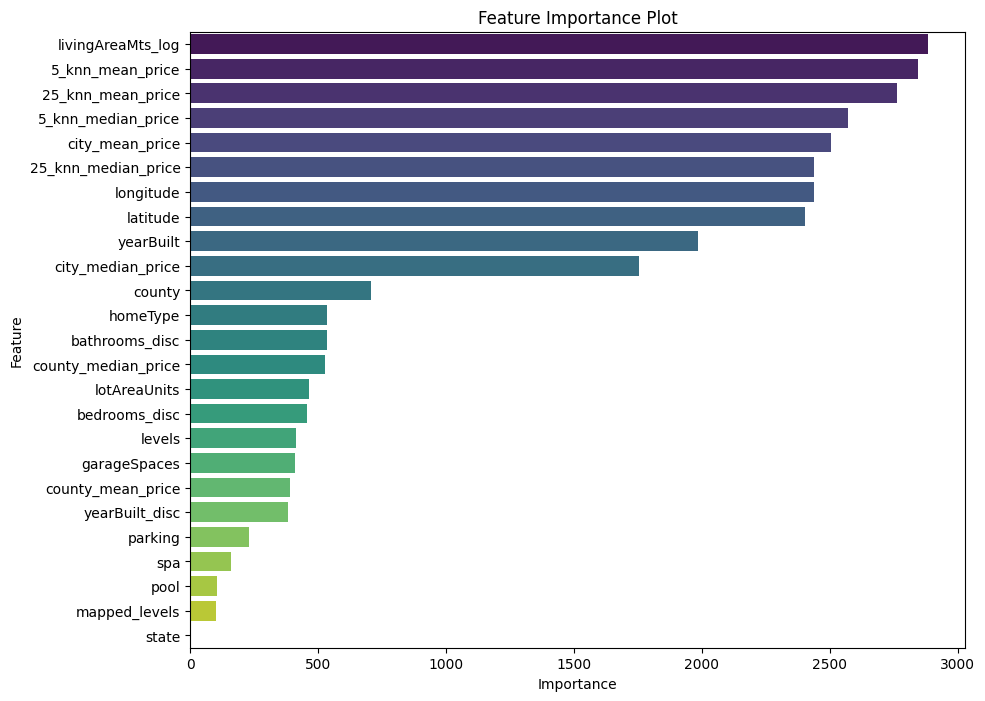

In [12]:
plot_feature_importance(model)

# Evaluate on testing

In [13]:
test_transformed = preprocessing_pipeline.transform(test.copy())

In [14]:
evaluate_test_set(test_transformed, model, target, decimals=3, log_inverse_transform=False)

RMSE: 448425.029
MSE : 201085006966.955
MAE : 253488.735
MeAE: 126767.403
MAPE: 0.511
R2  : 0.742


# Optuna

In [ ]:
from utils.optimizer import optimize_lightgbm_params
from utils.train import train_lightgbm_model

In [ ]:
train_transformed

In [ ]:
# Uso de la función
# Supongamos que tienes un DataFrame df y el objetivo es predecir la columna 'target'
best_params = optimize_lightgbm_params(train_transformed.drop(target, axis=1), train_transformed[target], n_trials=25)
print(best_params)

In [ ]:
model = train_lightgbm_model(train_transformed, target, best_params)

In [ ]:
evaluate_test_set(test_transformed, model, target, decimals=3)